# Running alchemical free energy calculations

`ASAP-Alchemy` provides a set of automated workflows which when combined create and end-to-end pipeline enabling the routine running of state-of-the-art alchemical free energy calculations at (Alchemi)scale! In this tutorial we cover configuring and executing each of the workflows via the python API, but note `ASAP-Alchemy` also provides a CLI which can be used to execute any of the workflows and accepts custom configuration files providing the same amount of flexibility as the API but with easier execution! We also have tried and tested defaults in all of our workflows which are used in production so feel free to skip configuring each workflow unless you really need the extra flexibility.

## General design
Each of the workflows in `ASAP-Alchemy` are designed following the same factory pattern which allows them to have a similar API which should make them all feel familiar. Each workflow then begins as a resuable configuration object which defines the runtime options of that pipeline which can then be applied to sets of molecules.

## ASAP-Alchemy Prep
The first stage in the workflow is called `prep` and has two main jobs:

- **State Enumeration**: Enumerate the tautomers, protomers and stereoisomers of the input ligands

- **Constrained Pose Generation**: Generate initial poses for the lignads while constraining the ligand to match the crystal structure reference conformation.

We will now walk through the process building a standard `AlchemyPrepWorkflow` and assigning the required component parts:

In [1]:
from asapdiscovery.alchemy.schema.prep_workflow import AlchemyPrepWorkflow
from asapdiscovery.data.operators.state_expanders.protomer_expander import EpikExpander
from asapdiscovery.data.operators.state_expanders.stereo_expander import StereoExpander
from asapdiscovery.docking.schema.pose_generation import (
    OpenEyeConstrainedPoseGenerator,
    RDKitConstrainedPoseGenerator,
)

prep_workflow = AlchemyPrepWorkflow()

## Stereo expansion

Molecules with unknown stereo centers should be fully expanded before generating an initial pose to ensure we know the exact identity of the molecule we are making the prediction for, this also allows us to predict free energy differeces between steroisomers which might offer more insight to your medicinal chemistry team. 

So lets add our `openeye` stereo expander module to the workflow and set it to only expand any undefined stereo centers in the input molecules:

In [2]:
stereo_expander = StereoExpander(stereo_expand_defined=False)
prep_workflow.stereo_expander = stereo_expander

## Charge and Tautomeric expansion

Druglike molecules often have multipule accessible protonation and tautomeric states at experimental pH which can contribute to binding and considering only a single state in alchemical free energy calculations can introduce significiant error. One option is to use tools like OpenEye to try and predict the most reasonable form of a molecule at the experimental pH in question, another is to enumerate all possible forms and and use a state pentalty correction scheme based on the predicted pKa of each state. You can read more about this at <https://pubs.acs.org/doi/10.1021/acs.jctc.8b00826>.

`ASAP-Alchemy` prodvies both of these enumeration options (`EpikExpander`, `ProtomerExpander`, `TautomerExpander`) however they are under active development and so by default we skip this stage by setting it to `None`:

In [3]:
prep_workflow.charge_expander = None

## Pose Generator

We now need to select a backend which will be used to generate the initial poses for our molecules. We have two options available `OpenEyeConstrainedPoseGenerator` and the `RDKitConstrainedPoseGenerator`. Both implimentations use the same general workflow to generate the poses, that is: find the MCS overlap between the target ligand and some reference ligand (normally extracted from a crystal reference structure) and constrain the overlaping atoms of the target ligand to match the reference; then, for any atoms not constrained, enumerate the rotamers of any rotable bonds using the backend toolkit and filter down to a single favorable conformer for each target ligand in the series. 

By default we use the `RDKitConstrainedPoseGenerator` as follows:

In [4]:
pose_generator = RDKitConstrainedPoseGenerator(
    max_confs = 300,  # The maximum number of conformers to try and generate
    rms_thresh = 0.2, # The RMSD between the heavy atoms which should be used to filter duplicated conformers
    mcs_timeout = 1, # The maximum time in seconds to the MCS search for 
    clash_cutoff = 2.0,  # The distance cutoff for which we check for clashes between poses and the receptor in Angstroms
    selector = 'Chemgauss3',  # The method which should be used to select the best conformer, an openeye docking score in this case
    backup_score = 'Sage', # If the main scoring function fails the intramolecular energies calculated with this force field will be used to select the best conformer
)
prep_workflow.pose_generator = pose_generator

## Core Smarts 

In some cases you may want to define the core yourself, or you may not want to constrain the full MCS between a target molecule and the reference ligand, in these cases you can provide a core SMARTS pattern which will be used to define the MCS. While [SMARTS](https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html) patterns can be created by hand we recomend using ChemDraw or <https://smarts.plus/>. By default we let the pose generator find the MCS which can be done by setting the `core_smarts` field to `None`.

In [5]:
prep_workflow.core_smarts = None

## Stereochemistry filtering

During the pose generation process some molecules may end up with inconsistent stereochemistry, that is the stereochemistry we intended does not match the 3D geometry of the molecule. This often happens when our reference ligand contains a stereocenter and the target ligand we are trying to pose has opposing stereochemsitry, in these cases a sensible pose can not be generated and often requires manual modeling of the reference to allow opposing stereocenters to be generated. To ensure all molecules have the correct stereo chemistry we set the `strict_stereo` flag to `True`:

In [6]:
prep_workflow.strict_stereo = True

## Experimental references

In prospective predictions it is desirable to not only predict a ranking of the molecules in the series but to predict the absolute binding affinity so that the results might be compared accross alchemical networks and against other ligands with experimental data which are not included in the network. 

In practice this is done by including experimental reference compounds in the alchemical network and then shifting the final predictions by the mean of the experimantal absolute binding afinities. `ASAP-Alchemy` allows users to provide a list of ligands with experimental data as references which we then try to generate poses for. From this list, `ASAP-Alchemy` will extract `n` suitable ligands to include in your network. 

The number of references to include from that list can be controlled via the `n_references` field which by default is set to 3:

In [7]:
prep_workflow.n_references = 3

This completes the construction of the default `AlchemyPrepWorkflow`, and we can now view the settings of the workflow

In [8]:
prep_workflow

AlchemyPrepWorkflow(type='AlchemyPrepWorkflow', stereo_expander=StereoExpander(expander_type='StereoExpander', stereo_expand_defined=False), charge_expander=None, pose_generator=RDKitConstrainedPoseGenerator(type='RDKitConstrainedPoseGenerator', clash_cutoff=2.0, selector=<PoseSelectionMethod.Chemgauss3: 'Chemgauss3'>, backup_score=<PoseEnergyMethod.Sage: 'Sage'>, max_confs=300, rms_thresh=0.2, mcs_timeout=1), core_smarts=None, strict_stereo=True, n_references=3)

## Saving and Loading

At this point, configured workflows can be saved and loaded to `JSON` meaning that a workflow can be reused multipule times throughout a project to ensure that a consistent pipeline is applied to an entire series of alchemical free energy calculations in a given project.

In [9]:
prep_workflow.to_file(filename="My-prep-workflow.json")
prep_workflow_2 = AlchemyPrepWorkflow.from_file("My-prep-workflow.json")

## Running Alchemy prep

We are now ready to run our configured prep workflow and create an alchemy dataset which can be used in the next sections of the guide. Lets inspect the function to create the dataset and generate the missing parts:

In [10]:
prep_workflow.create_alchemy_dataset?

Signature:
prep_workflow.create_alchemy_dataset(
    dataset_name: str,
    ligands: list[asapdiscovery.data.schema.ligand.Ligand],
    reference_complex: asapdiscovery.data.schema.complex.PreppedComplex,
    processors: int = 1,
    reference_ligands: Optional[list[asapdiscovery.data.schema.ligand.Ligand]] = None,
) -> asapdiscovery.alchemy.schema.prep_workflow.AlchemyDataSet
Docstring:
Run the set of input ligands through the state enumeration and pose generation workflow to create a set of posed
ligands ready for ASAP-Alchemy.

Notes:
    Ligands with experimental data can be supplied via `reference_ligands`, poses will be generated
    until `self.n_references` have been successfully added. The ligands will be sorted by their MCS overlap with
    the crystal reference ligand to ensure a pose can be generated.

Args:
    dataset_name: The name which should be given to this dataset.
    ligands: The list of input ligands which should be run through the workflow.
    reference_complex

First grab a reference complex, in this example we will use a real ASAP-enabled target ([SARS-CoV-2 NSP3 macrodomain](https://asapdiscovery.org/outputs/molecules/#ASAP-SARS-COV-2-NSP3-MAC1)) and download a prepared complex from the asapdiscovery test suite which includes a prepared receptor and ligand.

In [11]:
from asapdiscovery.data.testing.test_resources import fetch_test_file
from asapdiscovery.data.schema.complex import PreppedComplex

mac1_complex = PreppedComplex.parse_file(fetch_test_file("constrained_conformer/complex.json"))
mac1_complex


PreppedComplex(target=PreppedTarget(target_name='SARS2_Mac1A_A1496-ASAP-0008674-001', ids=None, data_format=<DataStorageType.b64oedu: 'b64oedu'>, target_hash='22bf5e21b05a8a454b5b64c52bcd95db83088d72636ee37cf37f166d71708331'), ligand=Ligand(compound_name='SARS2_Mac1A_A1496-ASAP-0008674-001_ligand', ids=None, provenance=LigandProvenance(isomeric_smiles='CC(C)[C@@H](c1ccc2c(c1)S(=O)(=O)CCC2)Nc3c4cc[nH]c4ncn3', inchi='InChI=1S/C19H22N4O2S/c1-12(2)17(23-19-15-7-8-20-18(15)21-11-22-19)14-6-5-13-4-3-9-26(24,25)16(13)10-14/h5-8,10-12,17H,3-4,9H2,1-2H3,(H2,20,21,22,23)/t17-/m0/s1', inchi_key='WLJITGAGZLIWOY-KRWDZBQOSA-N', fixed_inchi='InChI=1/C19H22N4O2S/c1-12(2)17(23-19-15-7-8-20-18(15)21-11-22-19)14-6-5-13-4-3-9-26(24,25)16(13)10-14/h5-8,10-12,17H,3-4,9H2,1-2H3,(H2,20,21,22,23)/t17-/m0/s1/f/h20,23H', fixed_inchikey='WLJITGAGZLIWOY-ZFFWTUEDNA-N'), experimental_data=None, expansion_tag=None, tags={}, conf_tags={}, data_format=<DataStorageType.sdf: 'sdf'>))

We now need a list of target molecules for which we want to estimate the binding afinity via relative free energy calculations, in this case we'll define some very simple molecules as an example:

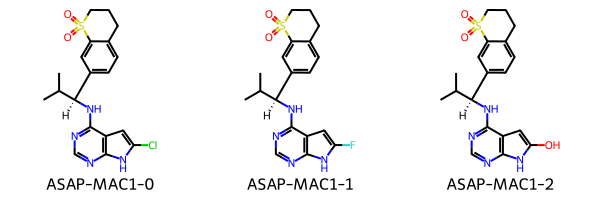

In [12]:
from asapdiscovery.data.schema.ligand import Ligand
from rdkit.Chem import Draw

molecules_smiles = [
    "CC(C)[C@H](Nc1ncnc2[nH]c(Cl)cc12)c4ccc3CCCS(=O)(=O)c3c4",
    "CC(C)[C@H](Nc1ncnc2[nH]c(F)cc12)c4ccc3CCCS(=O)(=O)c3c4",
    "CC(C)[C@H](Nc1ncnc2[nH]c(O)cc12)c4ccc3CCCS(=O)(=O)c3c4"
]
target_ligands = [
    Ligand.from_smiles(smiles=smiles, compound_name=f"ASAP-MAC1-{i}")
    for i, smiles in enumerate(molecules_smiles)
]
Draw.MolsToGridImage(mols=[mol.to_rdkit() for mol in target_ligands], legends=[mol.compound_name for mol in target_ligands])

Finally we can optionally pass in a set of reference ligands which can be added to the dataset to ensure the absolute predictions of the binding affinities are comparable with other experimental results. These ligands can be provided from any source so long as they are marked as experimental, we also provide tools to extract reference ligands from a [CDD vault](https://www.collaborativedrug.com/). Here we will make some example reference ligands:

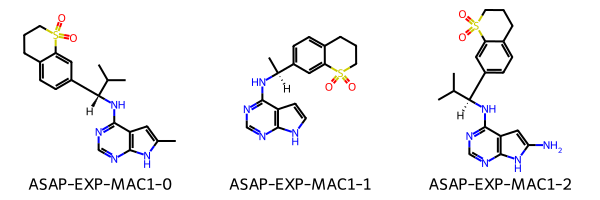

In [13]:
reference_smiles = [
    "Cc4cc3c(N[C@H](c2ccc1CCCS(=O)(=O)c1c2)C(C)C)ncnc3[nH]4",
    "C[C@H](Nc1ncnc2[nH]ccc12)c4ccc3CCCS(=O)(=O)c3c4",
    "CC(C)[C@H](Nc1ncnc2[nH]c(N)cc12)c4ccc3CCCS(=O)(=O)c3c4"
]
reference_ligands = [
    Ligand.from_smiles(smiles=smiles, compound_name=f"ASAP-EXP-MAC1-{i}", experimental=True)
    for i, smiles in enumerate(reference_smiles)
]
Draw.MolsToGridImage(mols=[mol.to_rdkit() for mol in reference_ligands], legends=[mol.compound_name for mol in reference_ligands])

We can now run the workflow and generate poses for the molecules, for this example we will reduce the number of conformers which should be generated as the modifications to the ligands are rigid and the conformer generation step is slow. In production it is recommended to use around 300 with RDKit.

In [14]:
# reduce the number of conformers just for this example
prep_workflow.pose_generator.max_confs = 10
alchemy_dataset = prep_workflow.create_alchemy_dataset(
    dataset_name="my-first-asap-dataset",
    ligands=target_ligands,
    reference_complex=mac1_complex,
    reference_ligands=reference_ligands,
)

Output()

[✓] StereoExpander successful,  number of unique ligands 3.

! WARNING the reference structure is chiral, check output structures carefully! 

Output()

[✓] Pose generation successful for 3/3.

[✓] Stereochemistry filtering complete 0 molecules removed.

Output()

Output()

[✓] Pose generation successful for 3/3 experimental ligands.

Poses successfully generated for 6 ligands.

We now have an alchemy dataset object which contains information about the workflow we have just ran including the inputs and any errors that might cause poses to not be generated for some ligands. We can also inspect provenance information about the stages run including the versions of software. For example, let's look at the pose generator and the software versions used:

In [15]:
alchemy_dataset.pose_generator


RDKitConstrainedPoseGenerator(
    type='RDKitConstrainedPoseGenerator',
    clash_cutoff=2.0,
    selector=<PoseSelectionMethod.Chemgauss3: 'Chemgauss3'>,
    backup_score=<PoseEnergyMethod.Sage: 'Sage'>,
    max_confs=10,
    rms_thresh=0.2,
    mcs_timeout=1
)

In [16]:
alchemy_dataset.provenance["RDKitConstrainedPoseGenerator"]


{
    'oechem': 20230910,
    'oeff': 20230910,
    'oedocking': 20230910,
    'rdkit': '2023.09.4',
    'openff.toolkit': '0.14.3'
}

We can also inspect the posed ligands and write them to file to view them:

In [17]:
alchemy_dataset.save_posed_ligands(filename='posed_ligands.sdf')
alchemy_dataset.posed_ligands[0]


Ligand(
    compound_name='ASAP-MAC1-2',
    ids=None,
    provenance=LigandProvenance(
        isomeric_smiles='CC(C)[C@@H](c1ccc2c(c1)S(=O)(=O)CCC2)Nc3c4cc([nH]c4ncn3)O',
        inchi='InChI=1S/C19H22N4O3S/c1-11(2)17(23-19-14-9-16(24)22-18(14)20-10-21-19)13-6-5-12-4-3-7-27(25,26)15(12)8-13/h5-6,8-11,17,24H,3-4,7H2,1-2H3,(H2,20,21,22,23)/t17-/m0/s1',
        inchi_key='SHBBKOWEJURVAN-KRWDZBQOSA-N',
        fixed_inchi='InChI=1/C19H22N4O3S/c1-11(2)17(23-19-14-9-16(24)22-18(14)20-10-21-19)13-6-5-12-4-3-7-27(25,26)15(12)8-13/h5-6,8-11,17,24H,3-4,7H2,1-2H3,(H2,20,21,22,23)/t17-/m0/s1/f/h22-23H',
        fixed_inchikey='SHBBKOWEJURVAN-UMUHEZHYNA-N'
    ),
    experimental_data=None,
    expansion_tag=None,
    tags={'Chemgauss3_score': '-65.13711547851562'},
    conf_tags={'Chemgauss3_score': ['-65.13711547851562']},
    data_format=<DataStorageType.sdf: 'sdf'>
)

We might want to view the ligands in the receptor and overlay the reference structure, so now we will write the reference receptor to a local PDB file and the ligand to an SDF file. You can then use your any molecule viewer (like PyMOL) or use the example below which uses `py3dmol`:

In [18]:
import py3Dmol
alchemy_dataset.reference_complex.target.to_pdb_file('mac1-receptor.pdb')
alchemy_dataset.reference_complex.ligand.to_sdf('mac1-ref-ligand.sdf')
view = py3Dmol.view(width=400, height=300)
view.addModel(open('mac1-receptor.pdb').read(), 'pdb')
view.setStyle({'chain':['A', 'B']}, {'cartoon': {'color': 'spectrum'}})
view.addModel(alchemy_dataset.reference_complex.ligand.to_sdf_str())
for mol in alchemy_dataset.posed_ligands:
    view.addModel(mol.to_sdf_str())
view.setStyle({'model': [i + 1 for i in range(len(alchemy_dataset.posed_ligands))]}, {"stick":{}})
view.zoomTo({'model':1})
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

This dataset object can then be saved to file and acts as a form of provenance for the `prep` workflow and should contain all of the information required to reproduce the dataset should someone want to repeate your work, i.e. all settings, versioning, ligand and protein structures, et cetera.

In [19]:
alchemy_dataset.to_file("my-alchemy-dataset.json")

## ASAP-Alchemy Plan

We are now ready to plan an alchemical free energy network using a state-of-the-art workflow based on [OpenFE](https://docs.openfree.energy/en/stable/) infastructure. The free energy calculations can also be configured for local or distributed execution using [Alchemiscale](https://github.com/openforcefield/alchemiscale). Following the format in the `prep` pipeline we start with an `FreeEnergyCalculationFactory` which we will configure component by component before appling it to our `alchemy_dataset` preppared above. 

This workflow handles the following stages:
- **Network Planning**: Choosing the optimal transformations between ligands based on some atom mapping and scoring metrics

- **Protocol Settings**: Defining the run time settings of the resulting network ready for execution using OpenFE

In [20]:
from asapdiscovery.alchemy.schema.fec import FreeEnergyCalculationFactory
from asapdiscovery.alchemy.schema.network import (
    NetworkPlanner, 
    KartografAtomMapper, 
    LomapAtomMapper, 
    PersesAtomMapper, 
    RadialPlanner,
    MaximalPlanner, 
    MinimalRedundantPlanner, 
    MinimalSpanningPlanner
)
alchemy_factory = FreeEnergyCalculationFactory()

## Network Planner

The first component of the `FreeEnergyCalculationFactory` is the the `NetworkPlanner` module which configures how the optimal transformations should be selected using OpenFE tooling and can be constructed via:

In [21]:
network_planner = NetworkPlanner()

### Atom Mapping Engine

Our free energy calculations by default use a hybrid topology approach and so an atom mapping which identifies the atoms of ligand A which should be alchemicaly transformed to atoms of ligand B is needed. Atoms that are not mapped should be consistend between ligands A/B. We currently support all of the available OpenFE atom mappers (LomapAtomMapper, PersesAtomMapper & KartografAtomMapper) but use Lomap by default which can be constructed as follows:

In [22]:
atom_mapper = LomapAtomMapper(
    timeout = 20, # The timeout in seconds of the MCS algorithm in rdkit
    threed = True, # If spatial information should be used to choose between symmetrically equivalent mappings 
    max3d = 1000, # Maximum discrepancy in Angstroms between atoms before the mapping is not allowed
    element_change = True, # Whether to allow element changes in the mappings
    seed = '', # An optional seed SMARTS string to speed up the MCS, if left blank this is automatically generated
    shift = True, # When determining 3D overlap translate the molecules to minimse the RMSD during alignment
)
network_planner.atom_mapping_engine = atom_mapper

### Transformation Scorer

Given the proposed atom mapping (which is generated between every possible combination of ligands in the target set) we need to choose the best edges to run during this campaign. To this end, OpenFE provides scoring metrics which rank the proposed atom mappings; our default is to use the lomap scorer:

In [23]:
network_planner.scorer = "default_lomap"

### Network Planning

Once we have all of the possible edges scored we then need to pick a strategy to build the network which will determine how many connections it has. The optimal network should provide a balance between speed (not too many edges), accuracy and redundancy. OpenFE provides many basic planning methods (`RadialPlanner`, `MaximalPlanner`, `MinimalSpanningPlanner`, `MinimalRedundantPlanner`) with more under active development. For now, our default is to use the `MinimalRedundantPlanner` which builds a minimal spanning tree ensuring all ligands are connected to the network but also adds `n` extra redundant edge(s) per node which ensures each node is in at least one cycle if `n`=1. `n` can be controlled by the user:

In [24]:
planning_method = MinimalRedundantPlanner(
    redundancy = 2
)
network_planner.network_planning_method = planning_method
network_planner


NetworkPlanner(
    type='NetworkPlanner',
    atom_mapping_engine=LomapAtomMapper(
        type='LomapAtomMapper',
        timeout=20,
        threed=True,
        max3d=1000.0,
        element_change=True,
        seed='',
        shift=True
    ),
    scorer='default_lomap',
    network_planning_method=MinimalRedundantPlanner(type='MinimalRedundantPlanner', redundancy=2)
)

The planner can then be saved to file like all `ASAP-Alchemy` workflows and reused throughout a discovery project or combined into our `FreeEnergyCalculationFactory`:

In [25]:
network_planner.to_file(filename='my-network-planner.json')
alchemy_factory.network_planner = network_planner

## Alchemy Protocol

We can now define the extensive set of runtime settings which will be used in the alchemical free energy calculations starting with the OpenFE protocol, so far only one is supported which is the `RelativeHybridTopologyProtocol` and all of the settings are directly related to this protocol. We plan on adding support for other types of calculations in the future so check back soon!

In [26]:
alchemy_factory.protocol = 'RelativeHybridTopologyProtocol'

### Solvent Settings

To accurately represent the experimental conditions our simulations will be performed in explicit solvent, and we begin by defining the settings of the solvent:

In [27]:
from asapdiscovery.alchemy.schema.fec import SolventSettings
from openff.units import unit
solvent = SolventSettings(
    smiles = "O", # The smiles pattern of the solvent
    positive_ion = "Na+", # The positive monoatomic ion which should be used to neutralize the system
    negative_ion = "Cl-", # The negative monoatomic ion which should be used to neutralize the system
    neutralize = True, # If we should add ions to neutralize the total charge of the system
    ion_concentration = 0.15 * unit.molar, # The ionic concentration required in molar units
)
alchemy_factory.solvent_settings = solvent

### Force Field Settings

The protocol also gives us control over the force fields used to parameterize all of the components of the system including the small molecule force field which allows for bespoke parameters (which we will be covering in a different tutorial). For now, we use the standard default settings but ensure that we always use the most recent OpenFF force field which at the time of writing is openff-2.1.0:

In [28]:
from gufe import settings
ff_settings = settings.OpenMMSystemGeneratorFFSettings(
    small_molecule_forcefield="openff-2.1.0"
)
alchemy_factory.forcefield_settings = ff_settings

### Thermodynamic Settings 

We can explicitly set the temperature and pressure of the simulation to ensure we match the experimental conditions:

In [29]:
thermo_settings = settings.ThermoSettings(
    temperature = 298.15 * unit.kelvin,
    pressure = 1 * unit.bar
)
alchemy_factory.thermo_settings = thermo_settings

<div class="alert alert-block alert-warning">
<b>Warning:</b> The next few sections offer advanced control over the simulation settings specific to OpenMM and are normally best left to their defaults!
</div>

### OpenMM System Settings

This allows to change the non-bonded settings in our simulation such as the method used to calculate the long-range charge interactions and the cutoff for short range non-bonded interactions.



In [30]:
from openfe.protocols.openmm_rfe.equil_rfe_settings import (
    AlchemicalSamplerSettings,
    AlchemicalSettings,
    IntegratorSettings,
    OpenMMEngineSettings,
    SimulationSettings,
    SolvationSettings,
    SystemSettings,
)
alchemy_factory.system_settings = SystemSettings()

### Solvation Settings

Not to be confused with solvent settings, the solvation settings control how the solvent will be added to the system, i.e. the water model used (3, 4 or 5 point water) and how much solvent should be added to ensure a minimum distance between the solutes and edge of the surrounding solvent.

In [31]:
alchemy_factory.solvation_settings = SolvationSettings()

### Alchemical Settings

This controls the used lambda schedule and the creation of the hybrid system:

In [32]:
alchemy_factory.alchemical_settings = AlchemicalSettings()

### Alchemical Sampler Settings

This defines the equilibrium sampler (ReplicaExchangeSampler, SAMSSampler or MultistateSampler) to use and its run time settings, currently we use `repex` (ReplicaExchangeSampler) by default. The only change we make here is to set the number of repeats to one. This means that each edge is only executed once in a single job and we instead do repeats by doing the calculation multiple times in parallel accross different GPUs via alchemiscale, see the `n_repeats` field on the `FreeEnergyCalculationFactory` class.

In [33]:
alchemy_factory.alchemical_sampler_settings = AlchemicalSamplerSettings(
    n_repeats = 1
)

### Engine Settings

OpenMM specific settings are defined here like the compute platform to use (CPU/GPU), by default we leave this as `None` which allows OpenMM to select the fastest available for us on the hardware that the simulations are run on:

In [34]:
alchemy_factory.engine_settings = OpenMMEngineSettings()

### Integrator Settings

We can also configure the settings used to build the `LangevinSplittingDynamicsMove` integrator in OpenMM such as the timestep or collison rate:

In [35]:
alchemy_factory.integrator_settings = IntegratorSettings()

### Simulation Settings

General settings about the simulation length are defined here:

In [36]:
simulation_settings = SimulationSettings(
    equilibration_length=1.0 * unit.nanoseconds,
    production_length=5.0 * unit.nanoseconds,
)
alchemy_factory.simulation_settings = simulation_settings

### Repeats

To ensure our estimation of the relative free energy is accurate we repeat each calculation and take the average prediction. We also use the standard deviation across repeats as an estimate of error. In the future this might also allow us to detect possible bad edges due to repeates differing significantly and remove these unreliable edges, although this functionality has not yet been built into `ASAP-Alchemy`. By default we do two repeats of each edge which means its run a total of three times and are submitted as different jobs on alchemiscale to increase throughput:

In [37]:
alchemy_factory.n_repeats = 2  

This then completes our `FreeEnergyCalculationFactory` which can now be saved to file and reused over the course of a campaign:

In [38]:
alchemy_factory.to_file("my-alchemy-factory.json")
alchemy_factory


FreeEnergyCalculationFactory(
    type='FreeEnergyCalculationFactory',
    solvent_settings=SolventSettings(
        type='SolventSettings',
        smiles='O',
        positive_ion='Na+',
        negative_ion='Cl-',
        neutralize=True,
        ion_concentration=<Quantity(0.15, 'molar')>
    ),
    forcefield_settings=OpenMMSystemGeneratorFFSettings(
        constraints='hbonds',
        rigid_water=True,
        remove_com=False,
        hydrogen_mass=3.0,
        forcefields=[
            'amber/ff14SB.xml',
            'amber/tip3p_standard.xml',
            'amber/tip3p_HFE_multivalent.xml',
            'amber/phosaa10.xml'
        ],
        small_molecule_forcefield='openff-2.1.0'
    ),
    thermo_settings=ThermoSettings(
        temperature=<Quantity(298.15, 'kelvin')>,
        pressure=<Quantity(0.986923267, 'standard_atmosphere')>,
        ph=None,
        redox_potential=None
    ),
    system_settings=SystemSettings(
        nonbonded_method='PME',
        nonbonded_c

## The FreeEnergyCalculationNetwork

We are now ready to create a `FreeEnergyCalculationNetwork` by applying our `alchemy_factory` to our `alchemy_dataset`. First, let's inspect the function and workout how to feed in our dataset:

In [39]:
alchemy_factory.create_fec_dataset?

Signature:
alchemy_factory.create_fec_dataset(
    dataset_name: str,
    receptor: gufe.components.proteincomponent.ProteinComponent,
    ligands: list['Ligand'],
    central_ligand: Optional[ForwardRef('Ligand')] = None,
    experimental_protocol: Optional[str] = None,
    target: Optional[str] = None,
) -> asapdiscovery.alchemy.schema.fec.FreeEnergyCalculationNetwork
Docstring:
 Use the factory settings to create a FEC dataset using OpenFE models.

Args:
    dataset_name: The name which should be given to this dataset, this will be used for local file creation or
        to identify on alchemiscale
    receptor: The prepared receptor to use in the FEC dataset.
    ligands: The list of prepared and state enumerated ligands to use in the FEC calculation.
    central_ligand: An optional ligand which should be considered as the center only needed for radial networks.
        Note this ligand will be deduplicated from the list if it appears in both.
    experimental_protocol: The name of

The function requires us to create a `gufe` `ProteinComponent` for the receptor and also has some optional fields which have not been covered yet. 

#### Optional Fields

- `central_ligand`: Only needed if we are using a `RadialPlanner` as our network planner method in which case you should provide the ligand and ensure its not passed in the ligands list as well. 

- `experimental_protocol`: Used to associate a CDD vault experimental protocol with the dataset which allows automated retrieval of experimental data (potencies) but in general is a useful source of provenance to know what experimental data the network should be compared against.

- `target`: The biological target for which the alchemical free energy network is being run for. Again, a useful source of provenance.

In [40]:
from gufe.components.proteincomponent import ProteinComponent

gufe_receptor = ProteinComponent.from_pdb_file('mac1-receptor.pdb')
fec_network = alchemy_factory.create_fec_dataset(
    dataset_name = alchemy_dataset.dataset_name,
    receptor = gufe_receptor,
    ligands = alchemy_dataset.posed_ligands,
    experimental_protocol = 'MAC1-protocol',
    target = "SARS-CoV-2-MAC1"
)

We now have a `FreeEnergyCalculationNetwork` which contains our planned network and all of the runtime settings needed to compute the edges using OpenFE. First lets inspect the network we just generated, you can see that during the `prep` workflow the settings and software versions used are saved to ensure the workflow is reproducible:

In [41]:
fec_network.network.dict(include={"atom_mapping_engine", "scorer", "network_planning_method", "provenance"})


{
    'atom_mapping_engine': {
        'type': 'LomapAtomMapper',
        'timeout': 20,
        'threed': True,
        'max3d': 1000.0,
        'element_change': True,
        'seed': '',
        'shift': True
    },
    'scorer': 'default_lomap',
    'network_planning_method': {'type': 'MinimalRedundantPlanner', 'redundancy': 2},
    'provenance': {'openfe': '0.14.0', 'lomap': '2.0.0-rc+156.g4b1f092', 'rdkit': '2023.09.4'}
}

We can also view the planned network using some OpenFE tools, as we can see each of the ligands has at least two connections in the graph corresponding to the level of redundancy we requested in the network planning method:

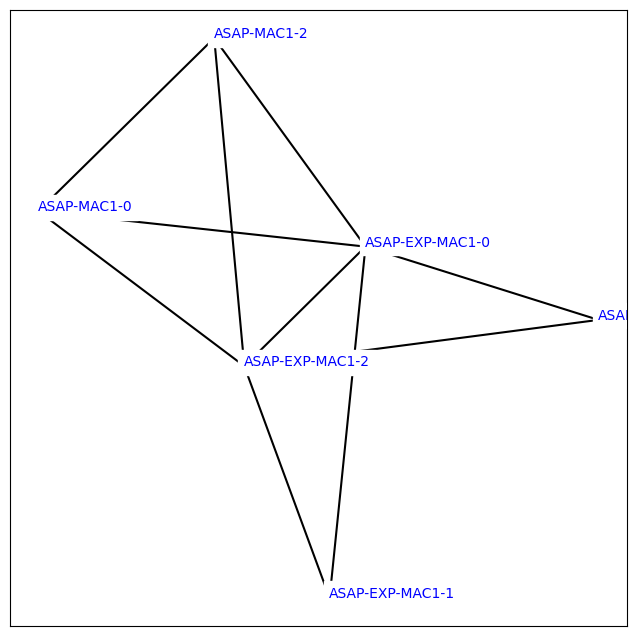

In [50]:
from openfe.utils.atommapping_network_plotting import plot_atommapping_network
%matplotlib inline
plot_atommapping_network(fec_network.network.to_ligand_network())

With the `OpenFE` CLI you can also view the `graphml` file for this network by running `openfe view-ligand-network <file>` which should pop up an interactive GUI view of the network for you to inspect the molecule structures and even the atom mapping per edge.

We can also inspect the individual edges of the network and the atom mappings generated which describe how the atoms will be transformed during a simulation:

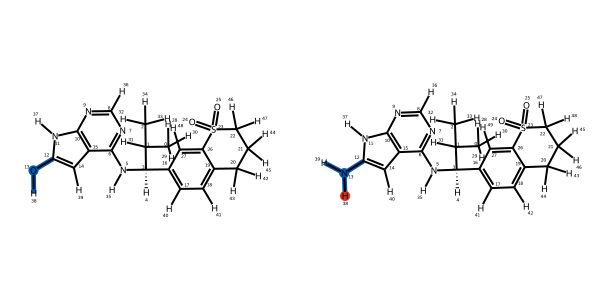

In [43]:
mapping = next(iter(fec_network.network.to_ligand_network().edges))
mapping

We can now save this network to file to execute later:

In [44]:
fec_network.to_file('fec-network.json')

## ASAP-Alchemy Submit

We are now ready to execute our alchemical network and estimate the relative binding affinity of the ligands. Currently there are two ways to do this locally with OpenFE or on distributed compute via Alchemiscale. At ASAP we use Alchemiscale exclusively allowing us to manage thousands of simultaneous calculations across many networks across many supercomputers, however it is very easy to also execute the calculations locally. We have an interface to simply convert the network to the OpenFE `AlchemicalNetwork` object and use either the CLI or API provided by OpenFE to execute the tasks see the [tutorials](https://docs.openfree.energy/en/stable/tutorials/index.html) for more information:

In [45]:
openfe_network = fec_network.to_alchemical_network()
openfe_network

<AlchemicalNetwork-dce63b77ae0806775462f27a0425785c>

We provide an Alchemiscale helper within `ASAP-Alchemy` to make it easier when working with our `FreeEnergyCalculationNetworks`s, this can be used to submit, execute, restart and gather results from an alchemiscale instance and is just a wrapper around the alchemiscale client. The class does require that your login `identifier` and `key` are set as the environment variables `ALCHEMISCALE_ID` and `ALCHEMISCALE_KEY` respectively:

In [46]:
import os
from asapdiscovery.alchemy.utils import AlchemiscaleHelper
from alchemiscale import Scope

os.environ["ALCHEMISCALE_ID"] = 'my-id'
os.environ["ALCHEMISCALE_KEY"] = 'my-key'
helper = AlchemiscaleHelper()

We can now create the network on the Alchemiscale instance using the helper which once complete will return a new copy of our `FreeEnergyCalculationNetwork` object with a results field setup and a network key which can be used to identify the network on Alchemiscale:

In [ ]:
submitted_network = helper.create_network(planned_network=fec_network, scope=Scope(org="MYORG", campaign="SARS_CoV_2_MAC1", project="mac1_testing"))

Now we need to create tasks for each of the transformations defined in our network and action them which queues them for execution. These two stages are handled by one convince method on the helper called `action_network`. Note that we now used the `submitted_network` version of our network as it contains the `network_key` used to find the network on Alchemiscale:

In [ ]:
task_keys = helper.action_network(planned_network=submitted_network)

Once all of the calculations have finished or once the results are needed the results can be gathered from alchemiscale using the `collect_results` helper function which returns a new copy of the `FreeEnergyCalculationNetwork` with results for the completed edges:

In [ ]:
network_with_results = helper.collect_results(planned_network=submited_network)

## ASAP-Alchemy Predict

Once we have a successful set of transformations we can estimate the absolute binding affinity of our ligands by combining the relative measures via the maximum likelihood estimator method implemented in cinnabar, a best practices method for reporting the results of free energy calculations. ASAP-Alchemy has an interface to Cinnabar to make it easy to turn the simulation results into useful information for the med chem team. For this example we will use the TYK2 network which has been curated as part of the [protein-ligand benchmark](https://github.com/OpenFreeEnergy/protein-ligand-benchmark) dataset, we have the results of a subsection of this network in our testing suite.

In [47]:
from asapdiscovery.alchemy.schema.fec import FreeEnergyCalculationNetwork
tyk2_network = FreeEnergyCalculationNetwork.from_file(fetch_test_file('tyk2_result_network.json'))
tyk2_network.results


AlchemiscaleResults(
    type='AlchemiscaleResults',
    results=[
        TransformationResult(
            type='TransformationResult',
            ligand_a='lig_ejm_31',
            ligand_b='lig_ejm_47',
            phase='solvent',
            estimate=<Quantity(-27.8338026, 'kilocalorie / mole')>,
            uncertainty=<Quantity(0.0371470415, 'kilocalorie / mole')>
        ),
        TransformationResult(
            type='TransformationResult',
            ligand_a='lig_ejm_42',
            ligand_b='lig_ejm_50',
            phase='complex',
            estimate=<Quantity(7.03463605, 'kilocalorie / mole')>,
            uncertainty=<Quantity(0.164472206, 'kilocalorie / mole')>
        ),
        TransformationResult(
            type='TransformationResult',
            ligand_a='lig_ejm_42',
            ligand_b='lig_ejm_43',
            phase='solvent',
            estimate=<Quantity(-20.251948, 'kilocalorie / mole')>,
            uncertainty=<Quantity(0.0450103031, 'kilocalo

We can see that the `tyk2_network` now has a results field which has references to the network on the alchemiscale instance and a set of `Transformationresults` which contain the results of each simulated edge of the network. As the OpenFE `RelativeHybridTopologyProtocol` simulates the `complex` and `solvent` phases separately we need to combine these to estimate the relative free energy between the ligands in the transformation. We can do this by using the interface with `cinnabar`:

In [48]:
measures = tyk2_network.results.to_cinnabar_measurements()
measures


[
    Measurement(
        labelA='lig_ejm_31',
        labelB='lig_ejm_47',
        DG=<Quantity(0.111550848, 'kilocalorie_per_mole')>,
        uncertainty=<Quantity(0.149755347, 'kilocalorie_per_mole')>,
        temperature=<Quantity(298.15, 'kelvin')>,
        computational=True,
        source='calculated'
    ),
    Measurement(
        labelA='lig_ejm_42',
        labelB='lig_ejm_50',
        DG=<Quantity(0.172554629, 'kilocalorie_per_mole')>,
        uncertainty=<Quantity(0.166535131, 'kilocalorie_per_mole')>,
        temperature=<Quantity(298.15, 'kelvin')>,
        computational=True,
        source='calculated'
    ),
    Measurement(
        labelA='lig_ejm_42',
        labelB='lig_ejm_43',
        DG=<Quantity(1.20362226, 'kilocalorie_per_mole')>,
        uncertainty=<Quantity(0.109251133, 'kilocalorie_per_mole')>,
        temperature=<Quantity(298.15, 'kelvin')>,
        computational=True,
        source='calculated'
    ),
    Measurement(
        labelA='lig_ejm_46',
 

We also convert directly to a `FEMap` object and use it to calculate the absolute binding affinity estimates, first let's draw a graph of the converted network to check we get the expected `9 edges` and `10 ligands`:

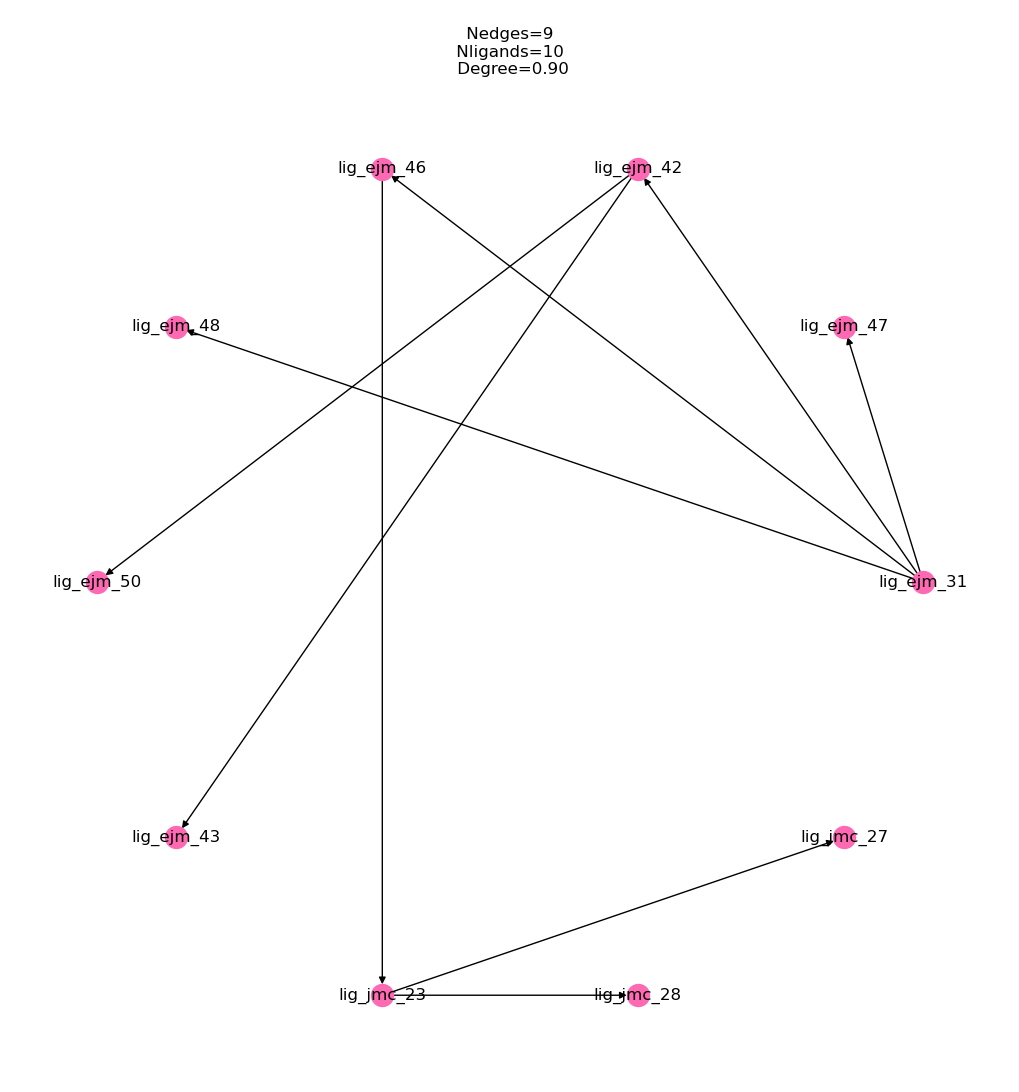

In [52]:
fe_map = tyk2_network.results.to_fe_map()
%matplotlib inline
fe_map.draw_graph()

Now we can check that the calculated relative affinities have been correctly converted and we can view them as a table:

In [53]:
fe_map.generate_absolute_values()
fe_map.get_relative_dataframe()

,labelA,labelB,DDG (kcal/mol),uncertainty (kcal/mol),source,computational
0,lig_ejm_31,lig_ejm_47,0.111551,0.149755,calculated,True
1,lig_ejm_31,lig_ejm_42,0.811265,0.086100,calculated,True
2,lig_ejm_31,lig_ejm_46,-0.753063,0.114680,calculated,True
3,lig_ejm_31,lig_ejm_48,0.904890,0.341134,calculated,True
4,lig_ejm_42,lig_ejm_50,0.172555,0.166535,calculated,True
5,lig_ejm_42,lig_ejm_43,1.203622,0.109251,calculated,True
6,lig_ejm_46,lig_jmc_23,0.076046,0.098778,calculated,True
7,lig_jmc_23,lig_jmc_28,-0.351981,0.134189,calculated,True
8,lig_jmc_23,lig_jmc_27,-0.358086,0.109293,calculated,True


We can now view the estimated absolute binding affinities for these molecules as a pandas table which we can use to rank our compounds and provide feed back to the med chem team:

In [54]:
fe_map.get_absolute_dataframe()

,label,DG (kcal/mol),uncertainty (kcal/mol),source,computational
0,lig_ejm_31,-0.133223,0.075722,MLE,True
1,lig_ejm_47,-0.021672,0.153867,MLE,True
2,lig_ejm_42,0.678041,0.093269,MLE,True
3,lig_ejm_46,-0.886286,0.091456,MLE,True
4,lig_ejm_48,0.771667,0.314375,MLE,True
5,lig_ejm_50,0.850596,0.175745,MLE,True
6,lig_ejm_43,1.881663,0.135084,MLE,True
7,lig_jmc_23,-0.810240,0.110756,MLE,True
8,lig_jmc_28,-1.162221,0.163317,MLE,True
9,lig_jmc_27,-1.168326,0.147726,MLE,True


Hold on those absolute affinities look a little off! You will notice that they are centred around `0` as we have no experimental reference or absolute affinity prediction to centre the results around. This is one of the reasons why we would inject experimentally measured ligands into the network during the prep stage described above. Luckily for this example, we have experimental data for all of the ligands, let's use cinnabar to assess the accuracy of our predictions vs experiment:

In [55]:
import pandas as pd
tyk2_reference_data = pd.read_csv(fetch_test_file('tyk2_reference_data.csv'))
for _, row in tyk2_reference_data.iterrows():
    fe_map.add_experimental_measurement(
        label=row['Molecule Name'],
        value=row['IC50_GMean (µM)'] * unit.micromolar,
        uncertainty=0 * unit.molar 
    )
fe_map.generate_absolute_values()

We can now plot the estimated relative binding affinities vs experiment:

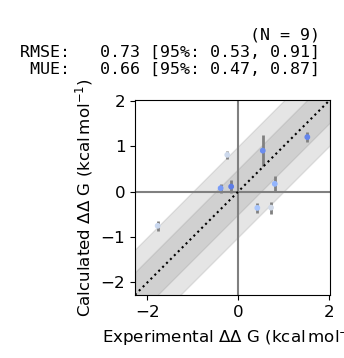

In [56]:
from cinnabar.plotting import plot_DDGs, plot_DGs
plot_DDGs(fe_map.to_legacy_graph())

Finally we can plot the estimated absolute binding afinities vs experiment:

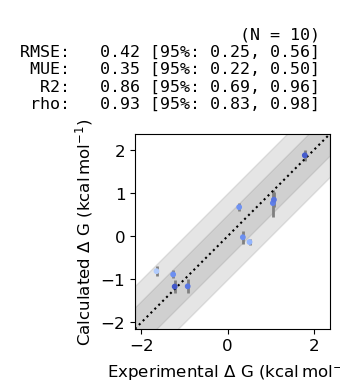

In [57]:
plot_DGs(fe_map.to_legacy_graph())

Before using the predictions in production it is common to benchmark the system under study to asses its suitability for free energy calculations, this normally involves curating a set of similar ligands which have reliable experimental measures of affinity and estimating their affinity using the production protocol. To help with debugging these benchmarks we have created some tools to produce interactive graphs to make it easier to identify outliers. Here we will generate interactive equivalents of the cinnabar graphs using `ASAP-Alchemy`. First, we use a utility function which extracts the absolute and relative predictions from the cinnabar `FEMap` and inserts experimental data extracted from a formatted csv file. Note that the absolute predictions are also automatically shifted to match the experimental range of binding affinity values:

In [58]:
from asapdiscovery.alchemy.predict import get_data_from_femap, create_absolute_report, create_relative_report
fe_map = tyk2_network.results.to_fe_map()
fe_map.generate_absolute_values()
absolute_df, relative_df = get_data_from_femap(
    fe_map=fe_map,
    ligands=tyk2_network.network.ligands,
    assay_units='IC50',
    reference_dataset=fetch_test_file('tyk2_reference_data.csv')
)

Now we can produce an interactive relative report to inspect each transformation and identify outliers and save this to an interactive HTML file:

In [59]:
relative_layout = create_relative_report(dataframe=relative_df)
relative_layout.save(
    filename='tyk2-relative.html',
    title='tyk2-benchmark',
    embed=True
)

The same can also be done for the absolute report:

In [60]:
absolute_layout = create_absolute_report(dataframe=absolute_df)
absolute_layout.save(
    filename='tyk2-absolute.html',
    title='tyk2-benchmark',
    embed=True
)

An interactive preview of these plots is shown below, try hovering over the points on the plot to identify the ligands involved in the transformation:

In [61]:
from bokeh.io import output_notebook, show
output_notebook()
from asapdiscovery.alchemy.predict import plotmol_relative, draw_mol

# manually create the plots which are generated as part of the report
mols, combined_smiles, titles = [], [], []
for _, data in relative_df.iterrows():
    smiles = ".".join([data["SMILES_A"], data["SMILES_B"]])
    combined_smiles.append(smiles)
    mols.append(draw_mol(smiles=smiles))
    titles.append((data["labelA"], data["labelB"]))
relative_df["Molecules"] = mols
relative_df["labels"] = titles
relative_df["smiles"] = combined_smiles
# create a plotting dataframe which drops rows with nans
plotting_df = relative_df.dropna(axis=0, inplace=False)
plotting_df.reset_index(inplace=True)
fig = plotmol_relative(
        calculated=plotting_df["DDG (kcal/mol) (FECS)"],
        experimental=plotting_df["DDG (kcal/mol) (EXPT)"],
        smiles=plotting_df["smiles"],
        titles=plotting_df["labels"],
        calculated_uncertainty=plotting_df["uncertainty (kcal/mol) (FECS)"],
        experimental_uncertainty=plotting_df["uncertainty (kcal/mol) (EXPT)"],
    )
show(fig)

Loading BokehJS ...